In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

In [62]:
import tensorflow as tf

In [63]:
x="Hi hello how are you"
print(len(x.split()))

5


In [64]:
import nltk
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords=stopwords.words("english")
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


In [65]:
url="https://raw.githubusercontent.com/Sooryak12/FakeReviewDetectionLSTM/master/selected.txt"


In [66]:
df=pd.read_csv(url,delimiter="\t")
df.head()

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [ ]:
df.isnull().sum()

In [ ]:
df["PRODUCT_CATEGORY"].value_counts()

In [67]:
df["LABEL"]=df["LABEL"].replace(['__label2__','__label1__'],['0','1'])

In [68]:
dfs=df[["REVIEW_TEXT","LABEL","PRODUCT_CATEGORY"]]
dfs = dfs.rename(columns={'REVIEW_TEXT': 'reviews',"LABEL":"label","PRODUCT_CATEGORY":"cat"})

In [69]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  21000 non-null  object
 1   label    21000 non-null  object
 2   cat      21000 non-null  object
dtypes: object(3)
memory usage: 492.3+ KB


In [70]:
dfs["reviews"]=dfs["reviews"].apply(lambda x:x.lower())
dfs["reviews"] = dfs["reviews"].apply(lambda x: re.sub("[^a-zA-Z]", " ", x))
dfs["reviews"] = dfs["reviews"].apply(lambda x: re.sub("\s+", " ", x))

In [71]:
dfs["label"].value_counts()

0    10500
1    10500
Name: label, dtype: int64

The Data is Unbiased

In [72]:
dfs.head()

,reviews,label,cat
0,when least you think so this product will save...,1,PC
1,lithium batteries are something new introduced...,1,Wireless
2,i purchased this swing for my baby she is mont...,1,Baby
3,i was looking for an inexpensive desk calcolat...,1,Office Products
4,i only use it twice a week and the results are...,1,Beauty


In [73]:
"not" in stopwords

True

In [74]:
#nltk.download('punkt')
def stop(text):
    clean_sent =[]
    for w in word_tokenize(text):
        if not w in stopwords:
            clean_sent.append(w)
    return (" ".join(clean_sent))

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):

    word_tokens = nltk.word_tokenize(text)
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens]
    return (" ".join(lemmatized_word))


In [75]:
dfs["reviews"]=dfs["reviews"].apply(lemmatize)
dfs["reviews"]=dfs["reviews"].apply(stop)

In [76]:
dfs["reviews"][10]

'unfortunately work made sick throw two time tried'

In [77]:
dfs["length"]=dfs["reviews"].apply(lambda x: len(x.split()))

In [78]:
dfs["length"].head()

0    10
1    40
2    22
3    21
4    27
Name: length, dtype: int64

In [79]:
dfs["reviews"][0]

'least think product save day keep around case need something'

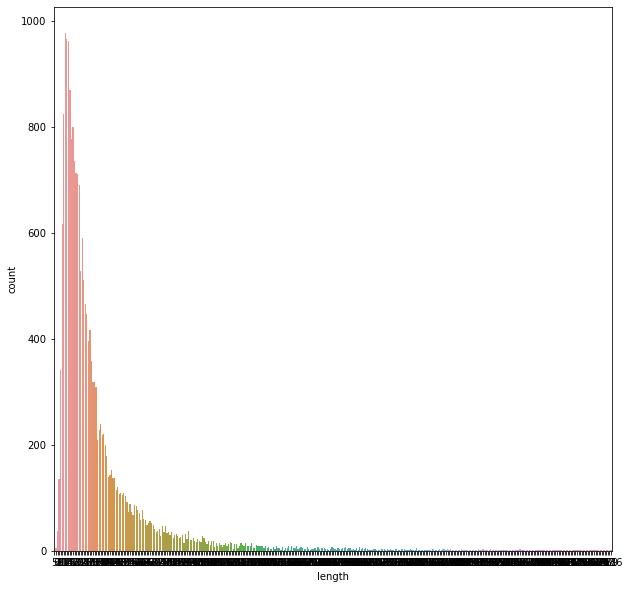

In [80]:
plt.figure(figsize=(10,10))
sns.countplot(dfs["length"])
plt.show()

In [81]:
np.mean(dfs["length"])

35.187714285714286

We see that there are many outliers and the data is heavily left skewed.So we have to do much more analysis to select the proper lenth for the text to embedd.

In [82]:
txt=" mean:{} \n median:{} \n maximum length:{} \n minimum length:{}".format(np.mean(dfs["length"]),np.median(dfs["length"]),np.max(dfs["length"]),np.min(dfs["length"]))

In [83]:
print(txt)

 mean:35.187714285714286 
 median:22.0 
 maximum length:1436 
 minimum length:5


In [84]:
def category(x):
    if 0<x<11:
        return 5
    elif 10<x<21:
        return 15
    elif 20<x<31:
        return 25
    elif 30<x<41:
        return 35
    elif 40<x<50:
        return 45
    elif 50<x<61:
        return 55
    elif 60<x<101:
        return 80
    elif 100<x<301:
        return 150
    elif 300<x<601:
        return 450
    elif 600<x<1001:
        return 800
    elif 1000<x<1501:
        return 1250
    

In [85]:
dfs["textcat"]=dfs["length"].apply(category)

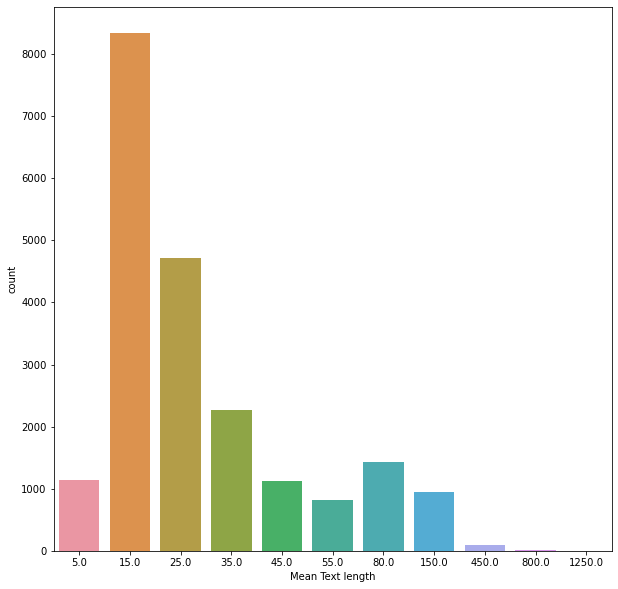

In [86]:
plt.figure(figsize=(10,10))
ax=sns.countplot(dfs["textcat"])
ax.set(xlabel="Mean Text length")
plt.show()

In [87]:
(15+25+35)/3

25.0

Ideal Text size will be of 30-40

In [88]:
c=0
for i in dfs["length"]:
    if 700<i:
      c+=1
print(c)

7


Texts with text size >700 is just 7 .We can remove them.
The above mentioned values are the index of outliers.

In [89]:
c=0
for i in dfs["length"]:
    if 40>i>1:
      c+=1
print(c)

16321


In [90]:
len(dfs["length"])

21000

In [91]:
19921/21000

0.9486190476190476

In [92]:
16321/21000

0.7771904761904762

In [93]:
19030/21000

0.9061904761904762

90% of the data lies with text size between 1 and 70.So we can remove all the other data.
77% of the data lies with text size between 40.As LSTM takes long time to train .This data is enough i guess.

In [94]:
dfs.columns

Index(['reviews', 'label', 'cat', 'length', 'textcat'], dtype='object')

In [95]:
dfs.head()

,reviews,label,cat,length,textcat
0,least think product save day keep around case ...,1,PC,10,5.0
1,lithium battery something new introduced marke...,1,Wireless,40,35.0
2,purchased swing baby month ha pretty much grow...,1,Baby,22,25.0
3,wa looking inexpensive desk calcolatur work do...,1,Office Products,21,25.0
4,use twice week result great used teeth whiteni...,1,Beauty,27,25.0


In [96]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   reviews  21000 non-null  object 
 1   label    21000 non-null  object 
 2   cat      21000 non-null  object 
 3   length   21000 non-null  int64  
 4   textcat  20891 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 820.4+ KB


In [97]:
dfs=dfs[dfs["length"]<41]

In [98]:
test_dfs=dfs

In [99]:
#dfs=test_dfs

In [100]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16461 entries, 0 to 20998
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   reviews  16461 non-null  object 
 1   label    16461 non-null  object 
 2   cat      16461 non-null  object 
 3   length   16461 non-null  int64  
 4   textcat  16461 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 771.6+ KB


In [101]:
dfs["label"]=dfs["label"].astype(np.float32)

we removed the outlier texts.

In [102]:
dfs["cat"].value_counts()

Jewelry                   648
Shoes                     633
Apparel                   622
Watches                   600
Office Products           584
Furniture                 580
Automotive                573
Home                      567
Wireless                  567
Musical Instruments       561
Outdoors                  556
Sports                    554
Tools                     554
Toys                      548
Lawn and Garden           546
Health & Personal Care    545
Luggage                   545
Home Improvement          539
Grocery                   537
Beauty                    536
Baby                      536
Video Games               534
Electronics               532
Pet Products              526
Kitchen                   524
PC                        523
Video DVD                 510
Camera                    505
Home Entertainment        459
Books                     417
Name: cat, dtype: int64

In [103]:
dfs["label"].value_counts()

1.0    8803
0.0    7658
Name: label, dtype: int64

In [104]:
dfs["reviews"][0]

'least think product save day keep around case need something'

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
dfs2=dfs

In [107]:
df_train,df_test,Ytrain,Ytest = train_test_split(dfs["reviews"],dfs["label"], test_size=0.2, random_state=101)

In [108]:
df_train[2]

'purchased swing baby month ha pretty much grown loud swing well beautiful though love color ha lot setting think wa worth money'

In [109]:
df_train

18322    love let driver know peaceful buddhist live st...
4183     finished reading certainly glad purchased book...
15057    love construction quality drawer drawer open s...
6018     juligo led headlamp comfortable wear cast nice...
449      stand paper towel soft feel like toilet paper ...
                               ...                        
2971     nothing like quality bed happy material though...
15747    bought shoe size chrat said size u eur receive...
6774     good price good size bought student sure love ...
9563     great game perfect beginner even veteran still...
16774    make short travel want organized buy today rig...
Name: reviews, Length: 13168, dtype: object

In [110]:
vocab={'pad':0,"unk":1}
for review in dfs["reviews"]:
    
    for word in review.split():
        if word not in vocab:
            vocab[word]=len(vocab)
print(len(vocab))

17189


In [111]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [112]:
MAX_VOCAB_SIZE=17200
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,oov_token="<OOV>")
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [113]:
word2idx = tokenizer.word_index
V = len(word2idx)

In [57]:
len(word2idx)

15598

In [117]:
print(len(df_train[0]),len(sequences_train[0]))

60 12


In [119]:
df_train[0]

'least think product save day keep around case need something'

In [120]:
sequences_train[0]

[7, 448, 1171, 88, 8468, 6385, 549, 1580, 6386, 1489, 5269, 461]

In [121]:
print(df_train[1])
print(sequences_train[1])

lithium battery something new introduced market average developing cost relatively high stallion compromise quality provides u best low cost br many built technical assistant act like sensor particular fort battery keep phone charged work every voltage high voltage never risked
[1300, 449, 770, 244, 77, 95, 12, 1202, 22, 1013, 716, 94, 449, 1229]


In [122]:
print(df_train[0])
print(sequences_train[0])
print(word2idx["least"])
print(word2idx["day"])


least think product save day keep around case need something
[7, 448, 1171, 88, 8468, 6385, 549, 1580, 6386, 1489, 5269, 461]
381
38


In [123]:

# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:',data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (13168, 40)


In [130]:
print(df_train[0])
print(data_train[0])

least think product save day keep around case need something
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    7  448 1171   88 8468 6385  549 1580 6386 1489 5269  461]


In [124]:

data_test = pad_sequences(sequences_test,maxlen=T)
print('Shape of data test tensor:',data_test.shape)

Shape of data test tensor: (3293, 40)


In [125]:
data_test

array([[    0,     0,     0, ...,    98,   175,     6],
       [    0,     0,     0, ...,   691, 12498,   345],
       [    0,     0,     0, ...,  4393,  2389,  2599],
       ...,
       [    0,     0,     0, ...,   343,  4485,     7],
       [    0,     0,     0, ...,     8,   168,   488],
       [    0,     0,     0, ...,   113,   283,   167]])

In [128]:
# create the model

# We get to choose embeding dimensionality
D = 20

# Hidden stats dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V+1) x D.
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V+1.

i = Input(shape=(T,))
x = Embedding(V+1,D)(i)
x = LSTM(M,return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x=Dense(64,activation="relu")(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

In [129]:
 #Compile and fit
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
print('Training model....')
r=model.fit(
    data_train,
    Ytrain,
    batch_size=64,
    epochs=10,
    validation_data=(data_test,Ytest)
)

Training model....
Train on 13168 samples, validate on 3293 samples
Epoch 1/10
13168/13168 [==============================] - 12s 911us/sample - loss: 0.6749 - accuracy: 0.5711 - val_loss: 0.6387 - val_accuracy: 0.6183
Epoch 2/10
13168/13168 [==============================] - 7s 535us/sample - loss: 0.5732 - accuracy: 0.7040 - val_loss: 0.6389 - val_accuracy: 0.6298
Epoch 3/10
13168/13168 [==============================] - 7s 521us/sample - loss: 0.4593 - accuracy: 0.7874 - val_loss: 0.7209 - val_accuracy: 0.6162
Epoch 4/10
13168/13168 [==============================] - 7s 546us/sample - loss: 0.3604 - accuracy: 0.8464 - val_loss: 0.7937 - val_accuracy: 0.6110
Epoch 5/10
13168/13168 [==============================] - 7s 543us/sample - loss: 0.2857 - accuracy: 0.8849 - val_loss: 0.9200 - val_accuracy: 0.6070
Epoch 6/10
13168/13168 [==============================] - 7s 552us/sample - loss: 0.2211 - accuracy: 0.9113 - val_loss: 1.0762 - val_accuracy: 0.6116
Epoch 7/10
13168/13168 [=======

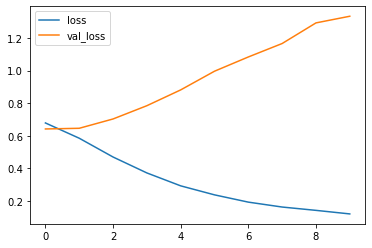

In [64]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

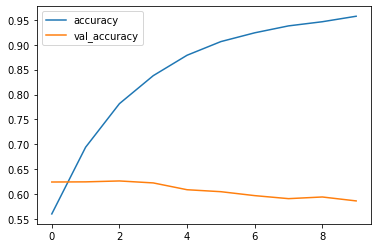

In [65]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
Without batch_size:
Epoch 10/10
13168/13168 [==============================] - 10s 788us/sample - loss: 0.1205 - accuracy: 0.9572 - val_loss: 1.3333 - val_accuracy: 0.5864
with batch_size=64:
Epoch 10/10
13168/13168 [==============================] - 4s 339us/sample - loss: 0.0331 - accuracy: 0.9891 - val_loss: 2.0885 - val_accuracy: 0.5858
